<a href="https://colab.research.google.com/github/Benendead/LSTMjazz/blob/master/Research/My_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
Author(s) | Year | Models Used | Music | Encoding | Quantization | Future work | Code/Examples
--- | ---
Eck | 2002 | LSTM | Melody + chords | 13 melody, 12 chord 1/0 | 2 per beat | N/A | [Ex](https://web.archive.org/web/20190104192500/http://people.idsia.ch/~juergen/blues/)
Bickerman | 2010 | DBN | Chords -> jazz licks | 18 melody (12 pitch, 4 8va), 12 chord | 12 per beat | Melodies avoid triplets | [Code](https://sourceforge.net/projects/rbm-provisor/)
Choi | 2016 | char-RNN, word-RNN | Jazz chord progressions | Note chars, Chord words | 1 per beat | N/A | [Code](https://github.com/keunwoochoi/lstm_real_book)
Lackner | 2016 | LSTM | Melody given chords | 24 melody, 12 chord 1/0 | 4 per beat | Larger dataset | [Ex](https://konstilackner.github.io/LSTM-RNN-Melody-Composer-Website/)
Agarwala | 2017 | Seq2Seq, char-RNN | Melodies | ABC char -> embeddings | None; ABC notation | N/A | [Code](https://github.com/yinoue93/CS224N_proj)
Brunner | 2017 | 2 LSTMs | Chords -> polyphonic piano | 48 melody, 50 chord embeddings | 2 per beat | Encoding polyphonic sustain, genre metadata | N/A
Hilscher | 2018 | char-RNN | Polyphonic piano | 1/0 on/off vectors | 4 per beat | More keys/data, text pattern matching | [Ex](https://yellow-ray.de/~moritz/midi_rnn/examples.html)

**To Consider:**
* My representation needs to have at least 12 steps per beat; triplets AND sixteenth notes are needed.
* Chords --> Melody has only one precedent for best practices.
* 2 of the 7 used chord embeddings.
* Methods to check overfitting are limited so far.
* 3 of the 7 benefitted from transposing to multiple keys.

# Representation Decisions

**Chords**  
We've really seen a few options for chords. These include:
* Text representations of chords quantized to quarter notes:  
 -START- F:9 F:9 F:9 F:9 D:min7 D:min7 G:9 G:9 C:maj C:maj F:9 F:9 C:maj C:maj C:maj C:maj -END-
* 0-11 bit vector encoding.
* Chord embeddings from unique bit vectors - Based on bits or on tokens? (Tokens better)



# Code Setup and Data Import

We import the necessary libraries, create a method to tranpose imported songs to C, and then import all songs.

In [0]:
!pip install music21

import music21 as m21
import glob

!git clone https://github.com/Benendead/LSTMjazz/

fatal: destination path 'LSTMjazz' already exists and is not an empty directory.


In [0]:
def formatStream(stream):
  m21.harmony.realizeChordSymbolDurations(stream)           # Fills out chords' proper durations.
  key = stream.analyze("key")                               # Finds how far off we are from C.
  i = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
  transposedStream = stream.transpose(i)                    # Transposes us that far to C.
  return transposedStream

In [0]:
# Import the songs and transpose them all to C.

streams = []
names = []
i = 1

# Selects all .xml files in the Datasets folder.
for xml_file in glob.glob("LSTMjazz/Datasets/*/*.xml"):
    if (i == 1 or i % 10 == 0):
      print("Processing song", i, ":", xml_file)
    newSong = m21.converter.parse(xml_file)
    formattedSong = formatStream(newSong)
    streams.append(formattedSong)
    songName = xml_file[32:-4]  # Formats xml_file to get the name of the song.
    names.append(songName)
    i = i + 1

Processing song 1 : LSTMjazz/Datasets/Omnibook Mxml/KC_Blues.xml
Processing song 10 : LSTMjazz/Datasets/Omnibook Mxml/Segment.xml
Processing song 20 : LSTMjazz/Datasets/Omnibook Mxml/Diverse.xml
Processing song 30 : LSTMjazz/Datasets/Omnibook Mxml/Thriving_From_A_Riff.xml
Processing song 40 : LSTMjazz/Datasets/Omnibook Mxml/Ornithology.xml
Processing song 50 : LSTMjazz/Datasets/Omnibook Mxml/Anthropology.xml


We now have all songs imported, transposed to C, and with fully realized chord durations.  
Rather than one copy of each song in C, let's create 12 copies of each song transposed to all 12 keys. I also include a method to transpose a song to a random key, as I'd already written the code.

In [0]:
import random

def transposeRandom(stream):
  """
  Transposes a given stream to a random key.
  """
  half_steps = random.randint(0,12) # Random number 0 to 11.
  i = m21.interval.Interval(half_steps)
  transposedStream = stream.transpose(i)
  return transposedStream

In [0]:
def transpose12(stream):
  """
  Returns a list of all 12 tranpositions of the given stream.
  """
  output = []
  for k in range(0,12):
    half_steps = k
    i = m21.interval.Interval(half_steps)
    transposedStream = stream.transpose(i)
    output.append(transposedStream)
  return output

In [0]:
expanded_streams = [] # This will have every transposed song in it; 600 total.
for stream_n in range(0,len(streams)):
  s = streams[stream_n]
  if (stream_n == 1 or stream_n % 5 == 0):
    print("Replicating song", stream_n, "of 50.")
  transposed_list = transpose12(s)
  expanded_streams.extend(transposed_list)
    
print("We have", 12*len(streams), "total songs.")

Replicating song 0
Replicating song 1
Replicating song 5
Replicating song 10
Replicating song 15
Replicating song 20
Replicating song 25
Replicating song 30
Replicating song 35
Replicating song 40
Replicating song 45
We have 600 total songs.


# Basic Dataset Analysis

Let's check out how long our songs are, as well as the range of their pitches.

In [0]:
def getDuration(stream):
  """
  Takes a Music21 stream and returns the total length of the chords in the stream.
  """
  part = stream.parts[0]
  sumDuration = 0
  
  for m in part:                                       # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      for c in m.notes:
        if isinstance(c, m21.harmony.ChordSymbol):     # For the chords...
          sumDuration = sumDuration + c.duration.quarterLength
  
  return sumDuration

In [0]:
durations = []

total = 0
for s in expanded_streams:
  duration = getDuration(s)
  durations.append(duration)
  total = total + duration
  
print("We have", total, "total beats of data.")

We have 169008.0 total beats of data.


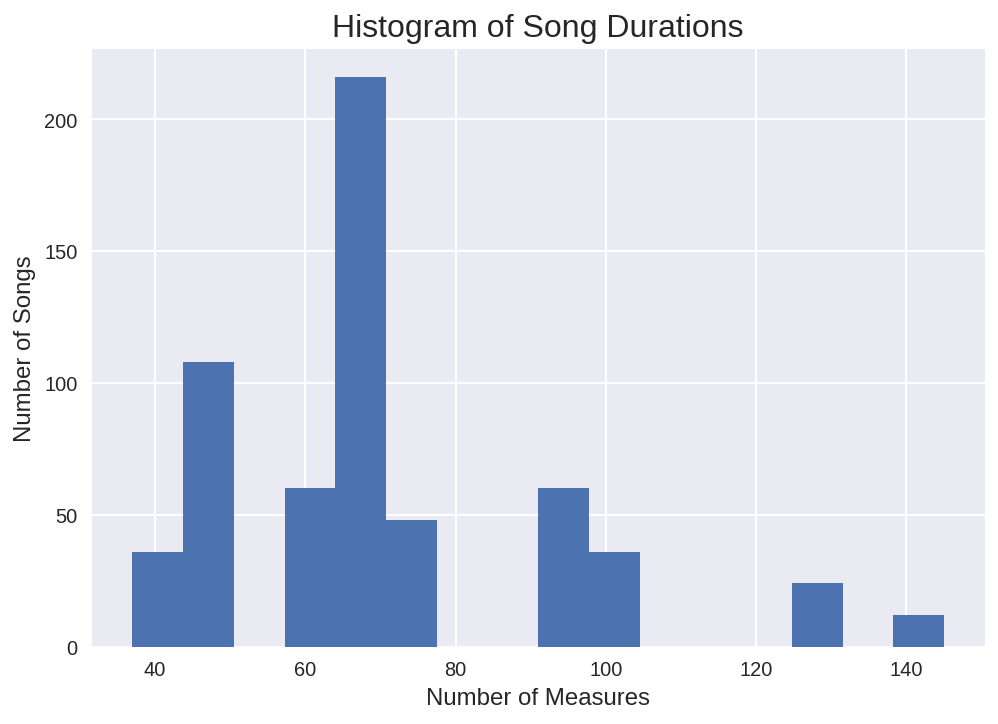

In [0]:
# Some insight into the durations of the songs we have.

import matplotlib.pyplot as plt
import numpy as np

n_bins = 16
x = np.array(durations) / 4

fig, ax = plt.subplots()

plt.title("Histogram of Song Durations", fontsize = 16)
plt.xlabel("Number of Measures", fontsize = 12)
plt.ylabel("Number of Songs", fontsize = 12)

hist = ax.hist(x, bins = n_bins) # We can set the number of bins for the histogram with the "bins" kwarg

Let's also check the keys of our now-transposed songs:

In [0]:
def getKey(stream):
  """
  Returns the key of the given stream as an int 0-11, with C = 0 and B = 11.
  """
  key = stream.analyze("key")  # A music21.key.Key object.
  tonic = key.tonic            # A music21.pitch.Pitch object.
  return tonic.pitchClass

In [0]:
key_labels_for_graphs = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

Processing song  1
Processing song  50
Processing song  100
Processing song  150
Processing song  200
Processing song  250
Processing song  300
Processing song  350
Processing song  400
Processing song  450
Processing song  500
Processing song  550
Processing song  600


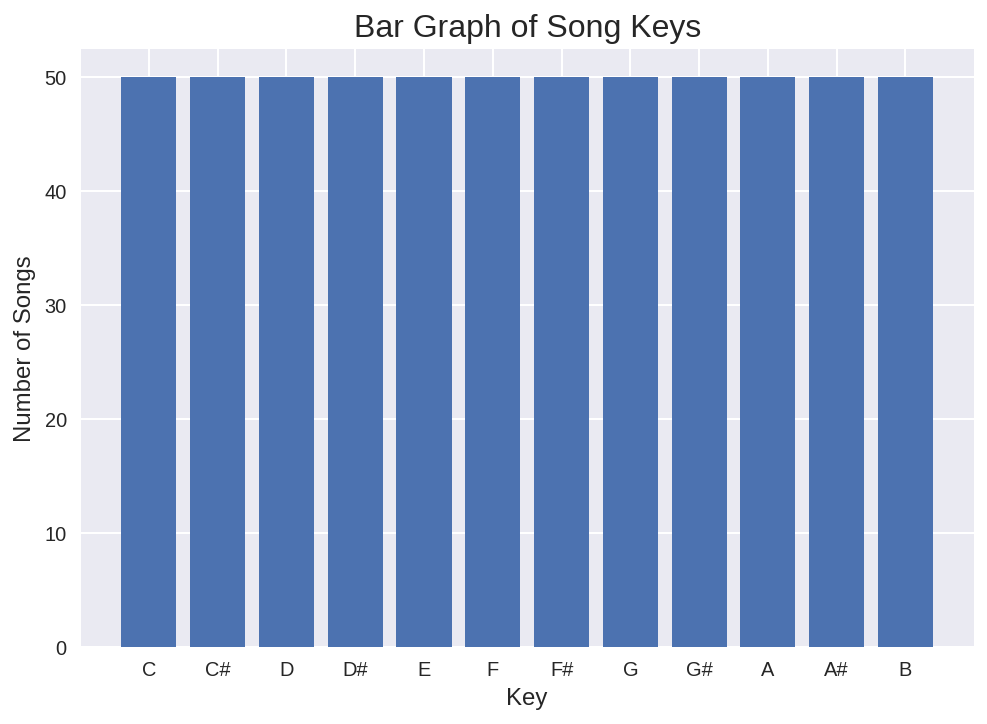

In [0]:
# Some insight into the keys of the songs we have.

keys = [0] * 12
counter = 1
for s in expanded_streams:
  if (counter == 1 or counter % 50 == 0):
    print("Processing song ", counter)
  k = getKey(s)
  keys[k] = keys[k] + 1
  counter = counter + 1

fig, ax = plt.subplots()

plt.title("Bar Graph of Song Keys", fontsize = 16)
plt.xlabel("Key", fontsize = 12)
plt.ylabel("Number of Songs", fontsize = 12)
plt.xticks(range(0,12), key_labels_for_graphs, fontsize = 10)

bar = ax.bar(range(0,12), keys)

We can see the duration and key of the songs we have, but what other metrics inform us about the melodies and harmonies within these songs? Let's look into what chords these songs now use. First, we want to find the "vocabulary" of the chords present. This entails adding one copy of each unique chord into a list.

### Unique Chord Counting Methods

#### Unique Chords Using Bit Encoding

In [0]:
def uniqueChordsAsBits(stream):
  """
  Returns a list of bit vectors representing the unique chords in
  this song. The bit vectors are 12 1/0 on/off bits for each note C-B in the chord.
  """
  chords = []
  
  part = stream.parts[0]
  
  # Collect the chords in the song.
  for m in part:                                     # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      for c in m.notes:
        if isinstance(c, m21.harmony.ChordSymbol):   # If this object is a chord...

          encoding = [0] * 12                        # Keep track of the notes on for this chord...
          for p in c.pitches:
            p.octave = 4
            num = int(p.midi - 60) % 12              # num will range from 0 to 11.
            encoding[num] = 1
          
          if encoding not in chords:
            chords.append(encoding)
  return chords

#### Unique Chords Using Token Encoding

In [0]:
def uniqueChordsAsTokens(stream):
  """
  Returns a list of tokens representing the unique chords in
  this song. The tokens are the chord symbols.
  """
  chords = []
  
  part = stream.parts[0]
  
  # Collect the chords in the song.
  for m in part:                                     # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      for c in m.notes:
        if isinstance(c, m21.harmony.ChordSymbol):   # If this object is a chord...

          symbol = str(c.figure)
          
          if symbol not in chords:
            chords.append(symbol)
  return chords

#### Combine + Count

In [0]:
def combineSets(set1, set2):
  """
  Combines the contents of two sets as to keep all elements unique.
  NOTE: Faster if set2 is the shorter one.
  """
  for e in set2:
    if e not in set1:
      set1.append(e)
  return set1

It's now time to find all unique chords in each song and then merge all 600 of these sets. We need to use token representations of the chords, not bit representations, to keep chord function information bits might otherwise lose.

In [0]:
uniqueChordsTokens = []

counter = 1
for s in expanded_streams:
  if (counter == 1 or counter % 50 == 0):
    print("Working through song " + str(counter) + "'s chords.")
  newChords = uniqueChordsAsTokens(s)
  uniqueChordsTokens = combineSets(uniqueChordsTokens, newChords)
  counter = counter + 1
  
print("We have", len(uniqueChordsTokens), "unique chords.")

Working through song 1's chords.
Working through song 50's chords.
Working through song 100's chords.
Working through song 150's chords.
Working through song 200's chords.
Working through song 250's chords.
Working through song 300's chords.
Working through song 350's chords.
Working through song 400's chords.
Working through song 450's chords.
Working through song 500's chords.
Working through song 550's chords.
Working through song 600's chords.
We have 84 unique chords.


In [0]:
uniqueChords = pd.DataFrame(uniqueChordsTokens)

So there we have it: 84 unique chords. But which of these chords is actually used often? Are there outlier chords that aren't worth encoding?

In [0]:
def findChordIndex(chord_symbol):
  """
  Finds the index of the given chord symbol within the uniqueChords dataframe.
  """

  target = uniqueChords.loc[uniqueChords[0] == chord_symbol]
  location = target.axes[0].tolist()
  row = location[0]
  return row

In [0]:
def countTokenUse(stream):
  """
  Returns a dataframe representing the unique chords in this song, as well as how much they're used.
  The tokens are the chord symbols and are the labels for the rows of the dataframe.
  The values in each row indicate the number of beats the given chord was used during this stream.
  """
  chords = []
  # TO BE CODED
  part = stream.parts[0]
  
  # Collect the chords in the song.
  for m in part:                                     # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      for c in m.notes:
        if isinstance(c, m21.harmony.ChordSymbol):   # If this object is a chord...

          symbol = str(c.figure)
          
          if symbol not in chords:
            chords.append(symbol)
  return chords


35

### Chord Encoding

In [0]:
# We also need to standardize the subdivision somewhere. We need 12 PPQ, as stated.
subdivide = 12

In [0]:
def findInt(vector):
  return uniqueChordSet.index(vector)

In [0]:
def processChordsToBitVectors(stream):
  """
  Create the 2D numpy array which will represent the chords of this song.
  NOTE: Vertical of the 2D array represents time.
        Horizontal represents the 12 possible chord notes for each tick.
  """
  duration = getDuration(stream)
  
  # subdivide is the number of subdivisions our data and thus model will consider per beat.
  ticks = int(duration * subdivide)  # The total number of "ticks" in this entire song
  
  # Create the numpy array to store the chord data.
  arr = np.zeros((ticks, 12))
  
  part = stream.parts[0]
  
  # Collect the chords in the song.
  for m in part:                                     # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      currOffset = int(m.offset * subdivide)         # This offset is in ticks.
      
      for c in m.notes:
        if isinstance(c, m21.harmony.ChordSymbol):   # If this object is a chord...
          ticksInChord = int(c.duration.quarterLength * subdivide)
          endOfChord = currOffset + ticksInChord
          
          notesInChord = []                          # Keep track of the notes on for this chord...
          for p in c.pitches:
            p.octave = 4
            num = int(p.midi - 60) % 12              # num will range from 0 to 11.
            notesInChord.append(num)
         
          for r in range(currOffset, endOfChord):    # For each row, representing all ticks in this chord...
            for n in notesInChord:                   # Set all the notes in this chord to 1 for these ticks.
              arr[r][n] = 1
          
          currOffset = currOffset + ticksInChord     # Account for two chords in a measure by adding the first chord to the offset.
          
  return arr

In [0]:
def checkRows(arr):
  # Verifies that each row of a 2D array has at least one bit activated.
  for row in arr:
    found = False
    for c in row:
      if (c == 1):
        found = True
    if (not found):
      print("Nothing in this row.")

So we're ready to extract the chords as bit vectors, at least:

In [0]:
chordBitVectors = []

i = 1
for s in expanded_streams:
  if (i == 1 or i % 50 == 0):
    print("Processing song", i)
  arr = processChordsToBitVectors(s)
  chordBitVectors.append(arr)
  i = i + 1

Processing song 1
Processing song 50
Processing song 100
Processing song 150
Processing song 200
Processing song 250
Processing song 300
Processing song 350
Processing song 400
Processing song 450
Processing song 500
Processing song 550
Processing song 600


In [0]:
# A light sampling of our results.

import pandas as pd

example = pd.DataFrame(chordBitVectors[0])
example.columns = key_labels_for_graphs
example.head(5).append(example.tail(5))

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1819,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1820,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1821,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1822,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1823,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


We also want the ability to process the chords as character representations, as was done in Choi et al. (2016). 

### Chord Token Strings

In [0]:
def processChordsToTokens(stream):
  """
  Create the 2D dataframe which will represent the chords of this song.
  NOTE: Vertical of the df represents time. Each row is one string.
  """
  duration = getDuration(stream)
  
  # subdivide is the number of subdivisions our data and thus model will consider per beat.
  ticks = int(duration * subdivide)  # The total number of "ticks" in this entire song
  
  # Create the numpy array to store the chord data.
  arr = np.zeros((ticks, 1))
  df = pd.DataFrame(arr)
  
  part = stream.parts[0]
  
  # Collect the chords in the song.
  for m in part:                                     # For measures in the song...
    if isinstance(m, m21.stream.Measure):
      currOffset = int(m.offset * subdivide)         # This offset is in ticks.
      
      for c in m.notes:
        if isinstance(c, m21.harmony.ChordSymbol):   # If this object is a chord...
          ticksInChord = int(c.duration.quarterLength * subdivide)
          endOfChord = currOffset + ticksInChord
          
          symbol = str(m21.harmony.chordSymbolFigureFromChord(c))
         
          for r in range(currOffset, endOfChord):    # For each row, representing all ticks in this chord...
            df.iloc[r,0] = symbol
          
          currOffset = currOffset + ticksInChord     # Account for two chords in a measure by adding the first chord to the offset.
          
  return df

In [0]:
chordTokens = []

i = 1
for s in expanded_streams:
  if (i == 1 or i % 5 == 0):
    print("Processing song", i)
  df = processChordsToTokens(s)
  chordTokens.append(df)
  i = i + 1
  if (i == 2):
    break

Processing song 1


In [0]:
chordTokens[0].head(10)

,0
0,G7
1,G7
2,G7
3,G7
4,G7
5,G7
6,G7
7,G7
8,G7
9,G7
